# Dimensionality reduction on mouse features coming from different splits

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import umap
from sklearn import mixture
from scipy.stats import entropy
from kneed import KneeLocator

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import trial_relative_frequency
functions_path = prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood, cluster_consensus, calculate_entropy, repeated_splits

from one.api import ONE
one = ONE(mode='remote')

## Get data

In [3]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial01-09-2025')
old_trial_clusters = pd.read_parquet(filename, engine='pyarrow')

# # Load trial clsuters
# results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
# filename = str(results_path + 'cluster_per_trial_no_timing03-11-2025')
# trial_clusters = pd.read_parquet(filename, engine='pyarrow')

# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial_no_timing03-19-2025')
trial_clusters = pd.read_parquet(filename, engine='pyarrow')

# Load entropy file
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'entropy03-21-2025')
ent = pd.read_parquet(filename, engine='pyarrow')

# Split sessions with random seed

In [4]:
random_state = 42
n_parts = 2

rng = np.random.default_rng(random_state)  # Random generator for reproducibility
# part_labels = []

trial_clusters['session_part'] = trial_clusters['response'] * np.nan

for s, session in enumerate(trial_clusters.session.unique()):
    session_df = trial_clusters.loc[trial_clusters['session']==session]
    n_trials = len(session_df)
    # Create shuffled labels for parts
    parts = np.tile(np.arange(n_parts), int(np.ceil(n_trials / n_parts)))[:n_trials]
    rng.shuffle(parts)  # Shuffle to randomize assignment
    # els.extend(parts)
    trial_clusters.loc[trial_clusters['session']==session, 'session_part'] = parts

# Assign to new column
trial_clusters['session_part'] = trial_clusters['session_part'].astype(str)
trial_clusters = trial_clusters.rename(columns={"sample": "old_sample"})
trial_clusters['sample'] = trial_clusters[['session', 'session_part']].agg(' '.join, axis=1)
# trial_clusters['sample'] = trial_clusters['old_sample'] + trial_clusters['session_part']

In [ ]:
file_to_save = trial_clusters.copy()
filename = "cluster_per_trial_part_info"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = '4.6_clustering_session_parts.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

# Cluster with consensus across repeats

In [ ]:
vars = ['mouse_name', 'cluster']
vars = ['sample', 'cluster']
# vars = ['session', 'cluster']

# Filter mice with multiple sessions
filter_mice = ent.loc[ent['session_len']>1, 'mouse_name']
use_data = trial_clusters.loc[trial_clusters['mouse_name'].isin(filter_mice)]
use_data = trial_clusters.copy()
# Prepare design matrix
count, freq_df = trial_relative_frequency(use_data, vars)
var_names = freq_df.keys()
ori_X = np.array(freq_df[var_names])

# Find optimal Ks
Ks = range(1, 10)
repeats = 10
# optimal_ks = Ks_iter (ori_X, repeats, Ks)
optimal_k = 3

# Cluster 
consensus_matrix = cluster_consensus(ori_X, optimal_k, shuffle=False, repeats=100)
# consensus_matrix_shuffled = cluster_consensus(ori_X, optimal_k, shuffle=True, repeats=100)


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

In [66]:
# Perform final clustering on consensus matrix
final_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage="average")
mouse_y_kmeans = final_clustering.fit_predict(1 - consensus_matrix)  # Convert to similarity

# Check stability: Compute variance of cluster assignments
cluster_stability = np.var(mouse_y_kmeans)
print("Cluster Stability Score:", cluster_stability)

Cluster Stability Score: 0.5773931855056788


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:566: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


## Prepare design matrix

In [67]:
var_names = freq_df.keys()
ori_X = np.array(freq_df[var_names]) #.values
print(np.shape(ori_X))

(215, 7)


## Run UMAP with fixed random seed

In [68]:
reducer = umap.UMAP(random_state= 42, n_components=2)

part_embedding = reducer.fit_transform(ori_X)
part_embedding.shape

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(215, 2)

## Save session part clusters data

In [69]:
swapped_kmeans = [1 if x == 0 else 0 if x == 1 else x for x in mouse_y_kmeans]

In [70]:
save_df = freq_df.copy()
save_df = save_df.merge(trial_clusters[['sample', 'mouse_name']].drop_duplicates(), on=['sample'])
save_df['UMAP1'] = part_embedding[:, 0]
save_df['UMAP2'] = part_embedding[:, 1]


save_df['part_cluster'] = swapped_kmeans
mouse_clustered_info = count.reset_index().merge(trial_clusters[['sample', 'mouse_name', 'cluster']].drop_duplicates(), on=['sample', 'cluster']).reset_index()
mouse_clustered_info = mouse_clustered_info.merge(save_df.reset_index()[['mouse_name', 'sample', 'part_cluster', 'UMAP1', 'UMAP2']], on=['mouse_name', 'sample'])

KeyError: 'sample'

In [ ]:
# save_df = freq_df.copy()
# save_df = save_df.merge(trial_clusters[['sample', 'mouse_name']].drop_duplicates(), on=['sample'])
# save_df['UMAP1'] = part_embedding[:, 0]
# save_df['UMAP2'] = part_embedding[:, 1]


# save_df['part_cluster'] = mouse_y_kmeans
# mouse_clustered_info = count.reset_index().merge(trial_clusters[['sample', 'mouse_name', 'cluster']].drop_duplicates(), on=['sample', 'cluster']).reset_index()
# mouse_clustered_info = mouse_clustered_info.merge(save_df.reset_index()[['mouse_name', 'sample', 'part_cluster', 'UMAP1', 'UMAP2']], on=['mouse_name', 'sample'])

In [72]:

# Mouse names in number for color code
unique_mouse_labels = np.arange(0, len(save_df.reset_index()['mouse_name'].unique()), 1)
map_mouse_names = dict(zip(save_df.reset_index()['mouse_name'].unique(), unique_mouse_labels))
mouse_name_numbers = save_df.reset_index()['mouse_name'].map(map_mouse_names)

In [20]:
file_to_save = mouse_clustered_info.copy()
filename = "cluster_per_session_part"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = '4.6_clustering_session_parts.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

## Visualize best k and clusters

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

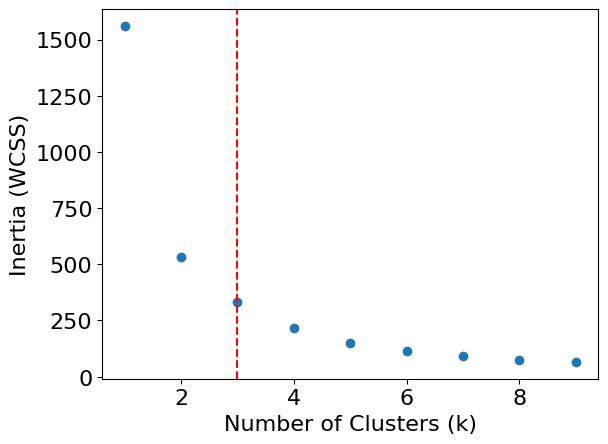

In [73]:
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
# Assuming `X` is your data
inertia_values = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(part_embedding)[0]*0.8)
    X_train = np.vstack([part_embedding[:cutoff, 0], part_embedding[:cutoff, 1]]).T
    kmeans.fit(X_train.copy())
    inertia_values.append(kmeans.inertia_)
    
kneedle = KneeLocator(K, inertia_values, curve="convex", direction="decreasing")
optimal_k = kneedle.knee
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
# Plotting the inertia values
plt.scatter(K, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
# plt.savefig(save_path+'inertia_values_session_part_clusters.svg', format="svg")

plt.show()

## K-means visualization using consensus kmeans

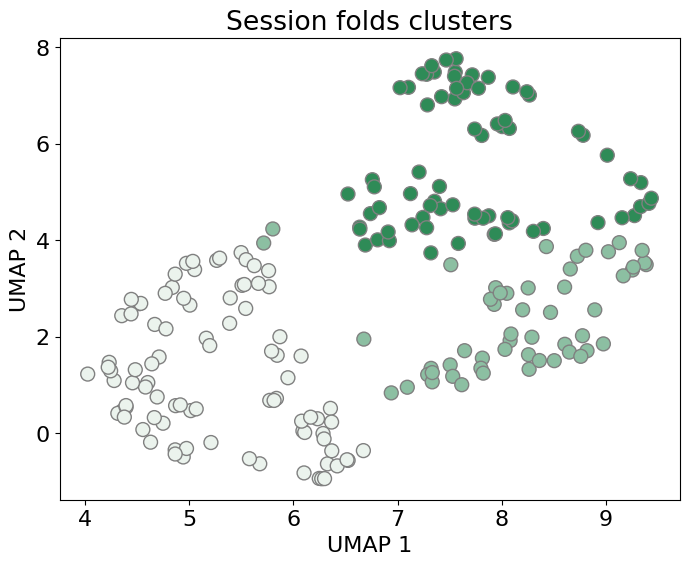

In [74]:
reducer = umap.UMAP(n_components=2)

part_embedding = reducer.fit_transform(ori_X)
part_embedding.shape

# Step 2: Perform KMeans Clustering
data_2d = part_embedding
# data_2d = ori_X
# kmeans = KMeans(n_clusters=3, random_state=2024)
# kmeans = KMeans(n_clusters=3)
# kmeans.fit(data_2d)
# mouse_y_kmeans = kmeans.predict(data_2d)

plt.rcParams.update({'font.size': 16})

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=swapped_kmeans,  edgecolors='grey', s=100, alpha=1, cmap=sns.light_palette("seagreen", 3, as_cmap=True))#, edgecolor='black',  cmap=sns.cubehelix_palette(as_cmap=True))

plt.title("Session folds clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.savefig(save_path+'part_clusters_umap.svg', format="svg")

plt.show()

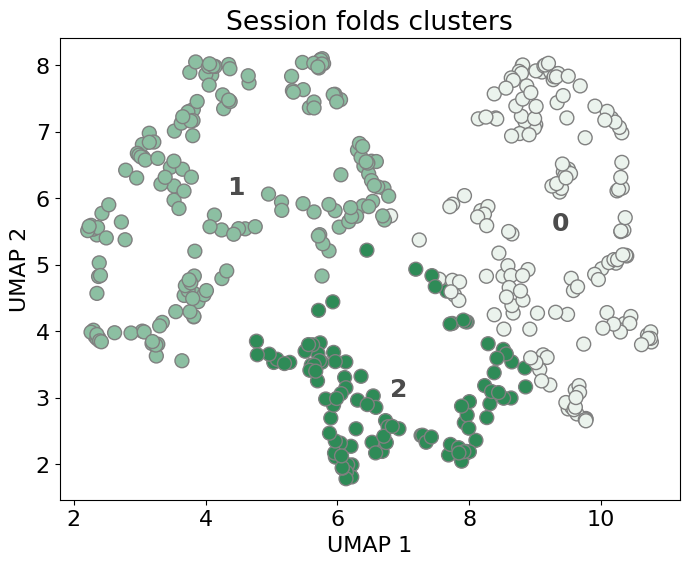

In [29]:
# Step 2: Perform KMeans Clustering
data_2d = part_embedding
# kmeans = KMeans(n_clusters=3, random_state=2024)
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_2d)
temp_y_kmeans = kmeans.predict(data_2d)
plt.rcParams.update({'font.size': 16})

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=temp_y_kmeans, s=100, alpha=1, edgecolors='grey', cmap=sns.light_palette("seagreen", 3, as_cmap=True))#, edgecolor='black',  cmap=sns.cubehelix_palette(as_cmap=True))


centroids = kmeans.cluster_centers_
for c, cent in enumerate(centroids):
    dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=0.7, fontsize=18, weight='bold')

plt.title("Session folds clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.savefig(file_path+'umap_mice.svg', format="svg")

plt.show()

# Kmeans only

In [54]:
save_df = freq_df.copy()
save_df = save_df.merge(trial_clusters[['sample', 'mouse_name']].drop_duplicates(), on=['sample'])
save_df['UMAP1'] = part_embedding[:, 0]
save_df['UMAP2'] = part_embedding[:, 1]

data_2d = ori_X
kmeans = KMeans(n_clusters=3, random_state=2024)
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_2d)
mouse_y_kmeans = kmeans.predict(data_2d)

save_df['part_cluster'] = mouse_y_kmeans
mouse_clustered_info = count.reset_index().merge(trial_clusters[['sample', 'mouse_name', 'cluster']].drop_duplicates(), on=['sample', 'cluster']).reset_index()
mouse_clustered_info = mouse_clustered_info.merge(save_df.reset_index()[['mouse_name', 'sample', 'part_cluster', 'UMAP1', 'UMAP2']], on=['mouse_name', 'sample'])

# Mouse names in number for color code
unique_mouse_labels = np.arange(0, len(save_df.reset_index()['mouse_name'].unique()), 1)
map_mouse_names = dict(zip(save_df.reset_index()['mouse_name'].unique(), unique_mouse_labels))
mouse_name_numbers = save_df.reset_index()['mouse_name'].map(map_mouse_names)

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
file_to_save = mouse_clustered_info.copy()
filename = "cluster_per_session_part"
save_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = '4.6_clustering_session_parts.ipynb'
mouse_clustered_info.to_parquet(save_path+filename) 
# metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

## Test entropy of cluster assignments

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

<Axes: xlabel='variable', ylabel='value'>

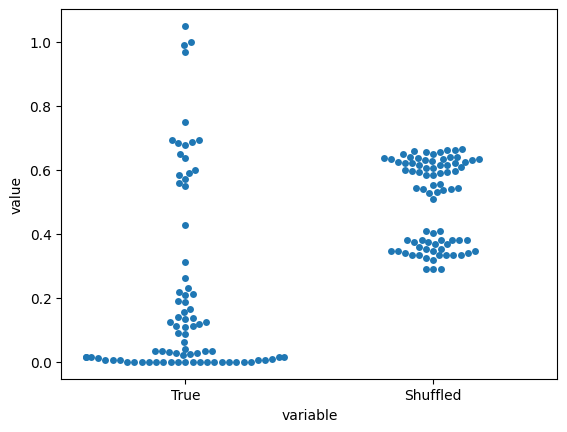

In [10]:
random_state = 42
n_parts = 2
vars = ['sample', 'cluster']
rng = np.random.default_rng()  # Random generator for reproducibility
# part_labels = []
all_cluster_repeats = repeated_splits(trial_clusters, vars, n_parts, rng, optimal_k=3, reps=100)
# melted_df = agreement_ratio(all_cluster_repeats)
melted_df = calculate_entropy(all_cluster_repeats)
sns.swarmplot(x='variable', y='value', data=melted_df)

### Test for session splits

In [59]:
all_cluster_repeats

,mouse_name,session,sample,y_kmeans,repeat,new_sample
0,SWC_038,03063955-2523-47bd-ae57-f7489dd40f15,03063955-2523-47bd-ae57-f7489dd40f15 0.0,2,0,0.0
1,SWC_038,03063955-2523-47bd-ae57-f7489dd40f15,03063955-2523-47bd-ae57-f7489dd40f15 1.0,2,0,1.0
2,SWC_053,032452e9-1886-449d-9c13-0f192572e19f,032452e9-1886-449d-9c13-0f192572e19f 1.0,2,0,1.0
3,SWC_053,032452e9-1886-449d-9c13-0f192572e19f,032452e9-1886-449d-9c13-0f192572e19f 0.0,0,0,0.0
4,CSHL045,034e726f-b35f-41e0-8d6c-a22cc32391fb,034e726f-b35f-41e0-8d6c-a22cc32391fb 0.0,2,0,0.0
...,...,...,...,...,...,...
42995,NYU-47,fc43390d-457e-463a-9fd4-b94a0a8b48f5,fc43390d-457e-463a-9fd4-b94a0a8b48f5 0.0,2,99,0.0
42996,CSH_ZAD_025,ff48aa1d-ef30-4903-ac34-8c41b738c1b9,ff48aa1d-ef30-4903-ac34-8c41b738c1b9 0.0,0,99,0.0
42997,CSH_ZAD_025,ff48aa1d-ef30-4903-ac34-8c41b738c1b9,ff48aa1d-ef30-4903-ac34-8c41b738c1b9 1.0,0,99,1.0
42998,ibl_witten_26,ff96bfe1-d925-4553-94b5-bf8297adf259,ff96bfe1-d925-4553-94b5-bf8297adf259 1.0,2,99,1.0


In [ ]:
all_cluster_repeats['new_sample'] = all_cluster_repeats['sample'].str.split().str[1:2].str.join('')

pivot_df = all_cluster_repeats.pivot(index=['session', 'repeat'], columns='new_sample', values='y_kmeans')

# Step 2: Compare clusters between folds
pivot_df['same_cluster'] = pivot_df['0.0'] == pivot_df['1.0']

# Step 3: If you want this result merged back into the original dataframe:
result = all_cluster_repeats.merge(pivot_df['same_cluster'], on=['session', 'repeat'])

mean_result = result.groupby(['session', 'mouse_name'])['same_cluster'].mean().reset_index()

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


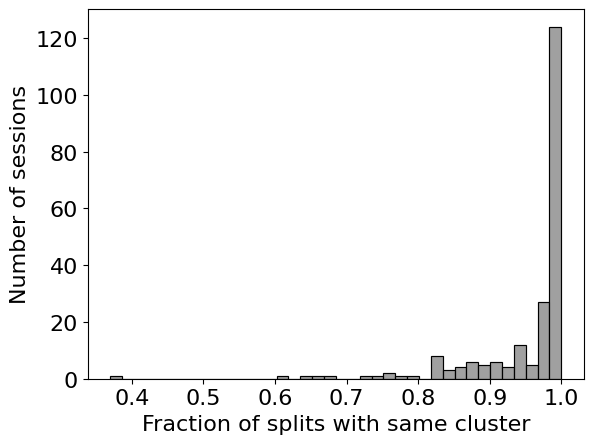

In [58]:
sns.histplot(x='same_cluster', data=mean_result, color='grey')
plt.ylabel('Number of sessions')
plt.xlabel('Fraction of splits with same cluster')
plt.rcParams.update({'font.size': 16})


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(29.222222222222214, 0.5, 'Cluster entropy')

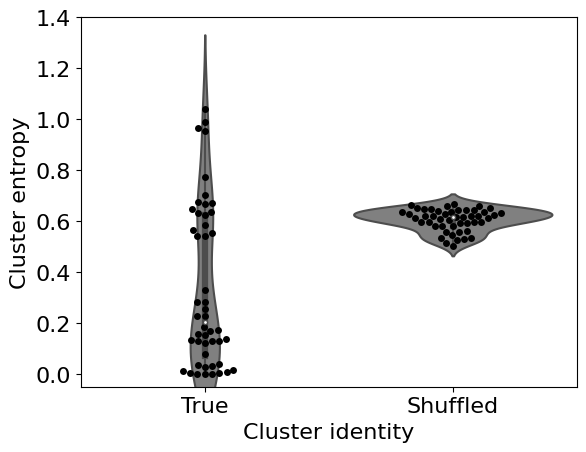

In [61]:
multiple = ent.loc[ent['session_len']>1]
sns.swarmplot(x='variable', y='value', data=multiple, color='black')
sns.violinplot(x='variable', y='value', data=multiple, color='grey')
plt.rcParams.update({'font.size': 16})
plt.ylim([-.05, 1.4])
plt.xlabel('Cluster identity')
plt.ylabel('Cluster entropy')
# plt.savefig(save_path+'entropy.svg', format="svg")

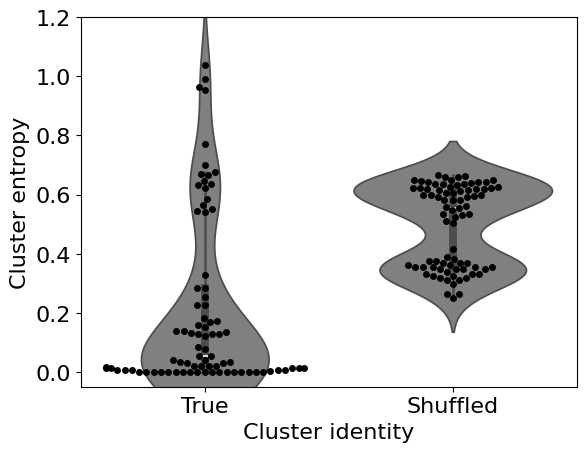

In [47]:
sns.swarmplot(x='variable', y='value', data=melted_df, color='black')
sns.violinplot(x='variable', y='value', data=melted_df, color='grey')
plt.rcParams.update({'font.size': 16})
plt.ylim([-.05, 1.2])
plt.xlabel('Cluster identity')
plt.ylabel('Cluster entropy')
plt.savefig(save_path+'entropy.svg', format="svg")


In [48]:
file_to_save = melted_df.copy()
filename = "entropy"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = '4.6_clustering_session_parts.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

## Test for cluster agreement

In [202]:
from scipy.stats import entropy
new_df = mouse_clustered_info.copy()
shuffle_iter = 100

cluster_entropy = pd.DataFrame(columns=['mouse_name', 'True', 'Shuffled', 'session_len'], index=range(len(new_df['mouse_name'].unique())))
for m, mouse in enumerate(new_df['mouse_name'].unique()):
    cluster_entropy['mouse_name'][m] = mouse
    
    mouse_session_parts = new_df.loc[new_df['mouse_name']==mouse][['mouse_name', 'sample', 'part_cluster']].drop_duplicates()

    # Compute maximum possible entropy (uniform distribution)
    # max_entropy = np.log2(len(prob))  # Since base=2
    
    # Count cluster label occurrences for sample i
    labels, counts = np.unique(np.array(mouse_session_parts['part_cluster']), return_counts=True)
    prob = counts / counts.sum()
    ent = entropy(prob)  # Shannon entropy
    # Normalize
    # normalized_entropy = ent / max_entropy if max_entropy != 0 else 0.0
    
    shuffles = []
    for i in range(shuffle_iter):
        shuffle = np.random.randint(np.min(new_df['part_cluster']), np.max(new_df['part_cluster']), len(mouse_session_parts))
        _, shuffle_counts = np.unique(shuffle, return_counts=True)
        shuff_prob = shuffle_counts / shuffle_counts.sum()
        shuff_ent = entropy(shuff_prob)  # Shannon entropy
        shuffles.append(shuff_ent)
        # Normalize
        # normalized_shuffle_entropy = shuff_ent / max_entropy if max_entropy != 0 else 0.0
        
    cluster_entropy['True'][m] = ent
    cluster_entropy['Shuffled'][m] = np.mean(shuffles)
    cluster_entropy['session_len'][m] = np.floor(len(mouse_session_parts['sample'].unique())/2)
    
    # print(labels, counts, ent)
    
    # sns.scatterplot(x='UMAP1', y='UMAP2', hue='session_cluster', data=new_df.loc[new_df['mouse_name']==mouse])
    # plt.xlim([-.5, 5])
    # plt.ylim([1.5, 10.5])
    # plt.show()

melted_df = pd.melt(cluster_entropy, id_vars=['mouse_name', 'session_len'], value_vars=['True', 'Shuffled'])

/tmp/ipykernel_16019/1447169909.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cluster_entropy['mouse_name'][m] = mouse
/tmp/ipykernel_16019/1447169909.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
Y

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(29.222222222222214, 0.5, 'Mouse cluster entropy')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 35.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


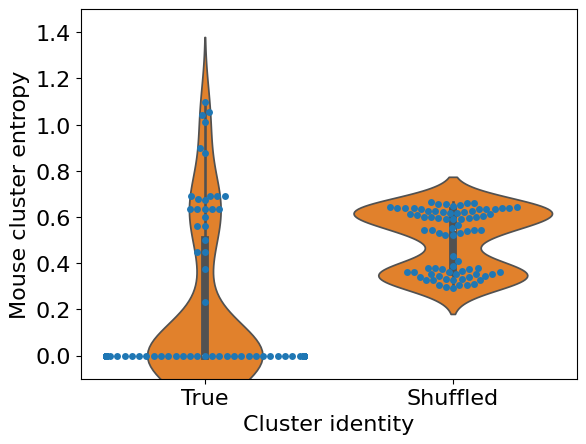

In [203]:
sns.swarmplot(x='variable', y='value', data=melted_df)
sns.violinplot(x='variable', y='value', data=melted_df)
plt.xlabel('Cluster identity')
plt.ylim([-.1, 1.5])
plt.ylabel('Mouse cluster entropy')

In [89]:
file_to_save = melted_df.copy()
filename = "entropy"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = 'H_clustering_mice.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

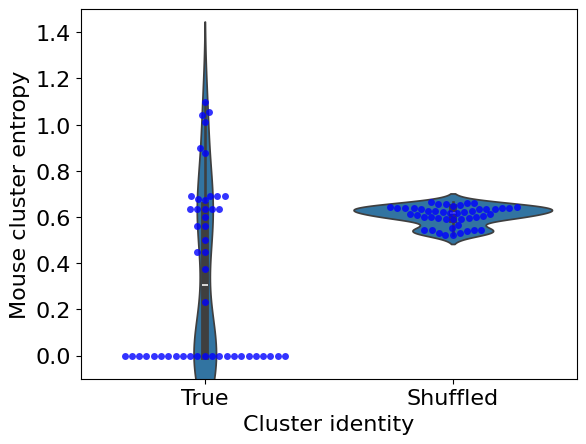

Text(29.222222222222214, 0.5, 'Mouse cluster entropy')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


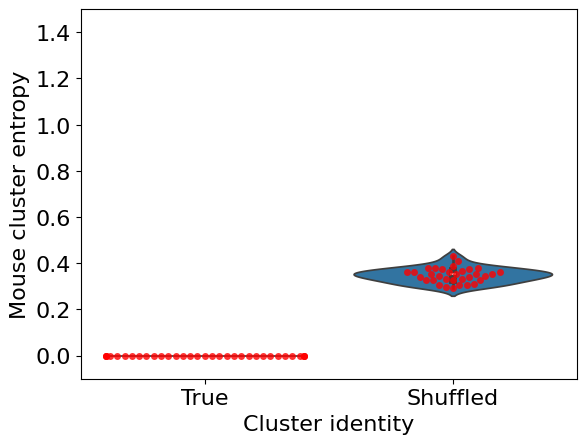

In [204]:
sns.swarmplot(x='variable', y='value', data=melted_df.loc[melted_df['session_len']>1], color='blue', alpha=.8)
sns.violinplot(x='variable', y='value', data=melted_df.loc[melted_df['session_len']>1])
plt.xlabel('Cluster identity')
plt.ylim([-.1, 1.5])
plt.ylabel('Mouse cluster entropy')
plt.show()

sns.swarmplot(x='variable', y='value', data=melted_df.loc[melted_df['session_len']<=1], color='red', alpha=.8)
sns.violinplot(x='variable', y='value', data=melted_df.loc[melted_df['session_len']<=1])
plt.xlabel('Cluster identity')
plt.ylim([-.1, 1.5])
plt.ylabel('Mouse cluster entropy')